In [1]:
%run CompareGPUOceanOpendriftParcels.ipynb

In [2]:
#Simulating gpu-ocean run OBS: only trajectory output
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
     }

outfolder = 'deterministic_forecast_test'

def simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land, sim_args,wind_drift_factor = 0.0, rescale=0,
                                    observation_type = dautils.ObservationType.UnderlyingFlow,
                                    outfolder = None, start_forecast_hours = 0, forecast_duration = 23 ):
    
    end_forecast_hours = start_forecast_hours + forecast_duration
    
    #Create simulator
    data_args = NetCDFInitialization.getInitialConditions(source_url, domain[0], domain[1], domain[2],domain[3] , 
                     timestep_indices = None, erode_land = erode_land, download_data = False)
    
    if wind_drift_factor:
        wind_data = data_args.pop('wind', None)
    else:
        wind_data = None
        
    if rescale:
        data_args = NetCDFInitialization.rescaleInitialConditions(data_args, scale=rescale)

    importlib.reload(CDKLM16)
    sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
    
    #Forecast
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }

    trajectory_forecast = Observation.Observation(**observation_args)

    if outfolder is not None:
        out_folder = os.path.abspath(outfolder)
        os.makedirs(out_folder, exist_ok=True)
        trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
        trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)
    
    #Drifters
    #Assumes initx, inity same format/shape
    if type(initx) is not list:
        initx = [initx]
        inity = [inity]
    
    num_drifters = len(initx)
    
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, wind = wind_data, 
                                                         wind_drift_factor = wind_drift_factor,
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = trajectory_forecast.domain_size_x,
                                                     domain_size_y = trajectory_forecast.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)
    
    drifter_pos_init = np.array([initx, inity]).T
    
    #Run simulation
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifters.setDrifterPositions(drifter_pos_init)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))
    
    if outfolder is not None:
        trajectory_forecast.to_pickle(trajectory_forecast_path)
    
    return trajectory_forecast


In [36]:
source_url = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

#lon, lat = 14.1,69.4
lon, lat = 9.2, 63.9
#lon, lat = 4.9, 60.0
hours = 12
ncfile = Dataset(source_url)
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

#Create OpendriftObject with norkys data to access coordinate-change lonlat2xy
reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
o = OceanDrift(loglevel=50)
o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity'])
initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(o, X, Y, lon, lat, 50,50)
domain = [x0,x1,y0,y1]
gpuobs = simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land = 1, sim_args = sim_args, wind_drift_factor = 0.02,
                                         outfolder = None, forecast_duration = hours )

09:16:26 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
09:16:26 INFO: Opening file with Dataset


922.0


'0% [##############################] 100%. Total: 20s, elapsed: 20s, remaining: 0s'

In [34]:
o1 = simulate_opendrift(source_url, lat, lon, 0.02, True, hours) #no wind, average velocity
o1obs = opendriftObj2gpuoceanObs(o1, X, Y, x0, x1,y0,y1)

09:16:11 INFO: OpenDriftSimulation initialised (version 1.2.3)
09:16:11 INFO: Config validation OK
09:16:11 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
09:16:14 INFO: Using existing reader for land_binary_mask
09:16:14 INFO: All points are in ocean
09:16:14 INFO: 2019-07-16 00:00:00 - step 1 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:05:00 - step 2 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:10:00 - step 3 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:15:00 - step 4 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:20:00 - step 5 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:25:00 - step 6 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:30:00 - step 7 of 144 - 1 active elements (0 deactivated)
09:16:14 INFO: 2019-07-16 00:35:00 - step 8 of

09:16:15 INFO: 2019-07-16 07:30:00 - step 91 of 144 - 1 active elements (0 deactivated)
09:16:15 INFO: 2019-07-16 07:35:00 - step 92 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 07:40:00 - step 93 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 07:45:00 - step 94 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 07:50:00 - step 95 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 07:55:00 - step 96 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:00:00 - step 97 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:05:00 - step 98 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:10:00 - step 99 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:15:00 - step 100 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:20:00 - step 101 of 144 - 1 active elements (0 deactivated)
09:16:16 INFO: 2019-07-16 08:2

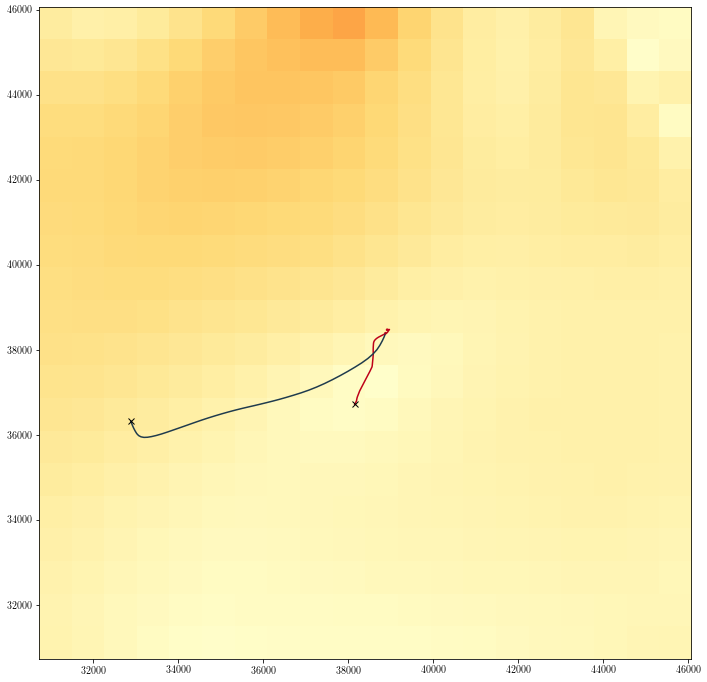

In [35]:
%matplotlib inline
ax = createForecastCanvas(gpuobs,background = True, url = source_url, domain = domain, zoom = 5)
plotAllDrifters(gpuobs, ax= ax, end = hours, color_id = 0)
plotAllDrifters(o1obs, ax=ax, end = hours, color_id = 2)

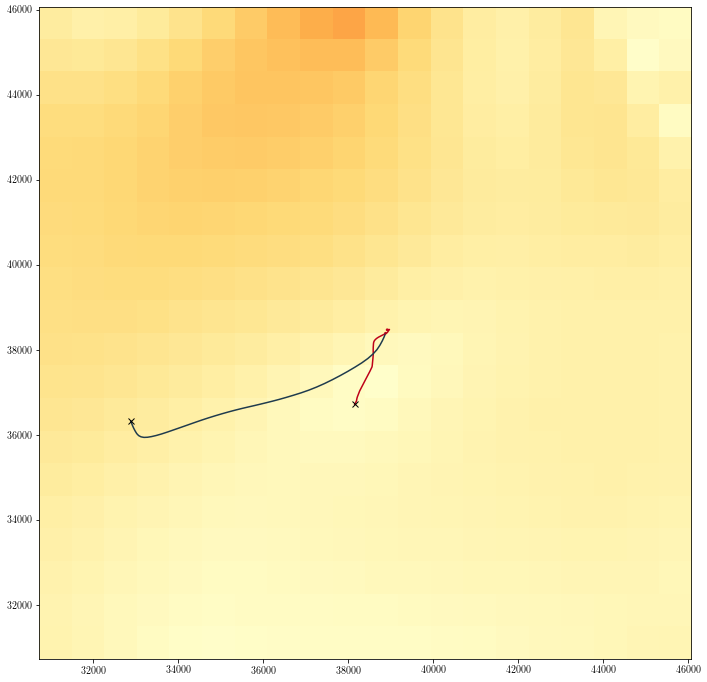

In [37]:
%matplotlib inline
ax = createForecastCanvas(gpuobs,background = True, url = source_url, domain = domain, zoom = 5)
plotAllDrifters(gpuobs, ax= ax, end = hours, color_id = 0)
plotAllDrifters(o1obs, ax=ax, end = hours, color_id = 2)